In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
data_path = '../data/cleandata/train.csv'
df = pd.read_csv(data_path)
df.head(5)

,ID,YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip,Value
0,1,1990,2102,1.0,0.77,2.0,1,27603,203200
1,2,1986,1740,1.5,0.06,3.0,1,27604,119096
2,3,1955,795,1.0,0.30,1.0,0,27610,71666
3,4,1983,1152,1.0,0.68,2.0,0,27616,131103
4,6,1924,1829,1.5,0.25,3.0,1,27607,496425


### 1. Examine the VIF of the features
All features have a VIF of less than 5, no multicollinearity is present.

In [28]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    # 为了计算 VIF，X 必须包含常数项
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.drop(0)  # 去掉常数项的 VIF

X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip']]
calculate_vif(X)


,feature,VIF
1,YearBuilt,1.361773
2,SqFt,2.208398
3,Story,1.740407
4,Acres,1.193651
5,Baths,2.059613
6,Fireplaces,1.532312
7,Zip,1.156841


In [29]:
# Fit the linear regression model without 'ID'
model = smf.ols('Value ~ YearBuilt + SqFt + Story + Acres + Baths + Fireplaces + Zip', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     31.48
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.66e-20
Time:                        12:33:32   Log-Likelihood:                -1091.9
No. Observations:                  88   AIC:                             2200.
Df Residuals:                      80   BIC:                             2220.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.031e+07   4.83e+06     -2.134      0.0

In [30]:
## Calculate LOOCV
# Get the number of observations
n = df.shape[0]
# Get the predicted values
pred = model.predict(df)
# Calculate the hat matrix
X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip']]
X = sm.add_constant(X)
hat = model.get_influence().hat_matrix_diag
# Calculate the residuals
resid = model.resid
LOOCV = np.sum((resid / (1 - hat))**2) / n
print('LOOCV:', LOOCV)
print('RMSE:', np.sqrt(LOOCV))

LOOCV: 4486032326.263776
RMSE: 66977.84951955218


Text(0, 0.5, 'Residual')

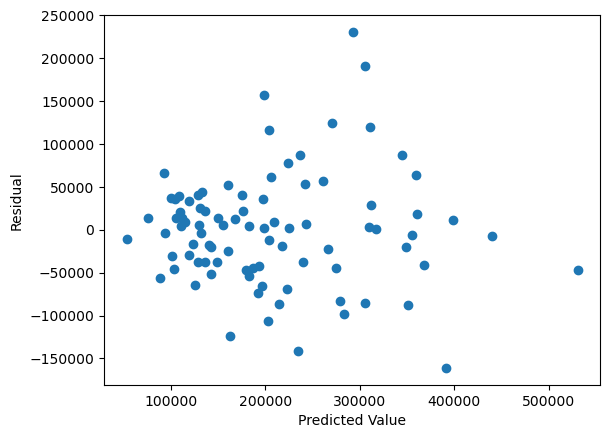

In [17]:
# residual plot
plt.scatter(pred, resid)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

### Best subset selection

In [37]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm

def best_subset_regression(X, y):
    """
    Perform best subset regression to find the best model with any number of predictors.
    
    Parameters:
        X (DataFrame): DataFrame containing predictor variables.
        y (Series): Series containing the response variable.
        
    Returns:
        results (DataFrame): DataFrame with details of each subset and their R² and AIC values.
        best_model (dict): Dictionary with details of the best subset model.
    """
    # Create lists to store results
    models = []
    
    # Iterate over all possible subset sizes
    for k in range(1, len(X.columns) + 1):
        # Iterate over all combinations of features of size k
        for combo in itertools.combinations(X.columns, k):
            # Fit the model with the selected subset of features
            X_subset = X[list(combo)]
            X_subset = sm.add_constant(X_subset)  # Add a constant term to the model
            model = sm.OLS(y, X_subset).fit()
            
            # Store the model performance metrics
            models.append({
                "num_features": k,
                "features": combo,
                "R_squared": model.rsquared,
                "Adj_R_squared": model.rsquared_adj,
                "AIC": model.aic
            })
    
    # Convert results to DataFrame for easier viewing and sorting
    results = pd.DataFrame(models)
    
    # Find the model with the highest R² or lowest AIC
    best_model_adj_r2 = results.loc[results["Adj_R_squared"].idxmax()]
    best_model_aic = results.loc[results["AIC"].idxmin()]
    
    # Return all results and the best model by R² and AIC
    return results, {"best_by_Adj_R2": best_model_adj_r2, "best_by_AIC": best_model_aic}

# 示例使用
# results, best_model = best_subset_regression(X, y)
# print("All model results:\n", results)
# print("Best model by R²:\n", best_model["best_by_R2"])
# print("Best model by AIC:\n", best_model["best_by_AIC"])

In [41]:
# Fit the best subset regression model
# X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip']]
X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip']]
y = df['Value']
results, best_model = best_subset_regression(X, y)
print("Best model by R²:\n", best_model["best_by_Adj_R2"])
print("Best model by AIC:\n", best_model["best_by_AIC"])

Best model by R²:
 num_features                                      4
features         (YearBuilt, SqFt, Fireplaces, Zip)
R_squared                                  0.728707
Adj_R_squared                              0.715632
AIC                                     2195.338691
Name: 72, dtype: object
Best model by AIC:
 num_features                                      4
features         (YearBuilt, SqFt, Fireplaces, Zip)
R_squared                                  0.728707
Adj_R_squared                              0.715632
AIC                                     2195.338691
Name: 72, dtype: object
